# Risk-targeted risk-parity portfolio: 

This document computes a similar diversified risk-targeted risk parity portfolio as the  [Man AHL TargetRisk](https://www.man.com/ahl-targetrisk) or [Ray Dalio's All weather portfolio](https://www.optimizedportfolio.com/all-weather-portfolio/). There are some key differences between each portfolio implementation, however, they both try to diversify, equalize the marginal risk contribution and rescale the portfolio to allow for a specific annualized risk level.  

Additional links:

https://portfolioslab.com/portfolio/ray-dalio-all-weather


https://info.recipeinvesting.com/t.pure.html



In [1]:
import yfinance as yf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import sympy as sp 
import seaborn as sns

In [2]:
def Riskparity(Sigma, b, risktarget) -> dict:
    """
    Sigma: covariance matrix, 
    b: Risk contributions. For riskparity this should 1/n for n being amount of assets in universe. 
    risktarget: Insert risktarget and rescales portfolio. For annualized value then do risktarget * sqrt(252) using the square-root rule. 
    """ 
    import cvxpy as cp
    import sympy as sp 

    w = cp.Variable(Sigma.shape[0])  #portfolio weight
    obj = 0.5 * cp.quad_form(w, Sigma) - cp.sum(cp.multiply(b, cp.log(w)))  
    #objective
    constr = [w >= 0] 
    prob = cp.Problem(cp.Minimize(obj), constr)
    prob.solve()

    # normalize weights as provided in Palomar documentation: 
    w = w/cp.sum(w)

    portrisk = cp.sqrt(cp.quad_form(w, Sigma))
    alpha = risktarget / portrisk
    w_new = w * alpha
    b_new = cp.multiply(w_new, Sigma @ w_new) / cp.quad_form(w_new, Sigma)  #solution risk budget af rescaling


    portrisk_new = cp.sqrt(cp.quad_form(w_new, Sigma))
    x = sp.Symbol('x')
    LC_Weight = sp.solve(np.sum(w_new.value) - x - 1, x)[0] #In order to provide leverage, we need to loan money from elsewhere (ie. from shorting or loaning from the bank). This is the Leverage cost weight. 


    out = {"w_new": w_new.value, "w": w.value, "b_new": b_new.value, "LC_weight": LC_Weight, "portrisk": portrisk.value, "portrisk_new": portrisk_new.value}

    return(out)

def EWMA(returns, lmb= 0.94) -> np.array:
    """ Computes the simple multivariate Exponentially Weighted Moving Average estimator.

    Args:
        returns (np.array or dataframe): array or dataframe of returns
        lambda (float): Dampening/halflife factor. 
    """

    covar = np.zeros((returns.shape[1], returns.shape[1], returns.shape[0]))


    #initiate covar using unconditional covariance: 

    covar[:,:,0] = returns.cov()

    for i in range(len(returns)-1):
        covar[:,:,i+1] = lmb * covar[:,:,i] + (1-lmb) * np.outer(returns.iloc[i,:],returns.iloc[i,:]) #returns.T @ returns

    return(covar)


def GMW_Weights(Cov) -> np.array:
    """Calculates the weights of the minimum variance portfolio using the closed-form solution. 

    Args:
        Cov (np.array): Covariance matrix

    Returns:
        np.array: weights for the GMV portfolio
    """
    v = np.ones(Cov.shape[0])

    num = np.dot(np.linalg.inv(Cov), v)
    den = np.dot(v.T ,np.dot(np.linalg.inv(Cov), v))
    w = num / den 
    return(w)


def Tangent_Weights(Cov, mu) -> np.array:
    """Calculates the weights of the Tangent portfolio using the closed-form solution

    Args:
        Cov (np.array): Covariance matrix
        mu  (np.array): Expected excess returns (mu - rf)

    Returns:
        np.array: Weights for the Tangent portfolio
    """
    v = np.ones(Cov.shape[0])

    num = np.dot(np.linalg.inv(Cov), mu)
    den = np.dot(v.T, num)

    w = num / den 
    return(w)


def Turnover(w) -> np.array:
    """Calculates the daily turnover as provided in De Miguels popular paper, 'Optimal Versus Naive Diversification:
       How Inefficient is the 1/N Portfolio Strategy?'. Be aware that his presentation is a rolling turnover. 

    Args:
        w (np.array): weights including the leverage constraints

    Returns:
        np.array: the turnover of the portfolio. 
    """
    res = np.squeeze(np.sum(np.abs(np.diff(w, axis=0)), axis = 1)) 

    return(res)


In [593]:

Sigma = np.array([[6.1, 2.9, -0.8, 0.1], 
                  [2.9, 4.3, -0.3, 0.9], 
                  [-0.8, -0.3, 1.2, -0.7],
                  [0.1, 0.9, -0.7, 2.3]])
b = np.ones(4)/4  #risk parity

risktarget = 0.1


In [595]:
#under square-root rule, we want the annualized volatility to be 10%, 0.1 * sqrt(252)
ll = Riskparity(Sigma, b, 0.1) #Correct. 
ll

{'w_new': array([0.02054821, 0.01692221, 0.07103755, 0.0407674 ]),
 'w': array([0.13765305, 0.11336237, 0.47588258, 0.273102  ]),
 'b_new': array([0.25000017, 0.24999975, 0.24999992, 0.25000017]),
 'LC_weight': -0.850724634656198,
 'portrisk': array(0.6699029),
 'portrisk_new': array(0.1)}

In [3]:
tickers = ["SPY", "GLD", "TLT", "HYG", "TIP"] #Stocks, Gold, Longterm Treasuries, Corporate bonds (High Yield), Treasure inflation protected bonds (a bet on rising inflation).
data = []

Start = '2002-01-01'
End = '2022-04-01'


for i in tickers: 
    stockdata = yf.download(i, start = Start, end = End)[['Adj Close', 'Volume']]
    data.append(stockdata['Adj Close'])


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
#We assume that the risk-free asset has zero variance, are uncorrelated with the
#risky assets and have an annualized return following the yield to maturity of a 1-year treasury bill transformed
#from percentage annualized values to daily decimal-values by dividing with 100 * 365.


#360 day count & annualized. 
RiskFreeRate = yf.download('^TNX', start=Start, end=End)
RiskFreeRate = RiskFreeRate['Adj Close'].dropna()
rf = RiskFreeRate.apply(lambda x: x/360 )/100

DF = pd.DataFrame(data).T
DF.columns = tickers
DF = DF.dropna(axis = 0)
DF = pd.merge(DF, rf, how = 'inner', on = 'Date')
DF = DF.rename(columns={'Adj Close': 'RF'})

[*********************100%***********************]  1 of 1 completed


In [5]:
#Rule of thumb: For anything other than modelling, do NOT use percentage returns. 

DF_Returns = pd.DataFrame(DF.iloc[:,0:5].pct_change().dropna() * 100 , index=DF.index[1:], columns=DF.columns[0:5]).subtract(DF['RF'][1:] * 100, axis = 0) #Working with linear returns for portfolio modelling. 
DF_LOGReturns = pd.DataFrame(np.diff(np.log(DF.iloc[:,0:5]) * 100, axis =  0), index=DF.index[1:], columns=DF.columns[0:5]).subtract(np.log(1 + DF['RF'][1:]) * 100, axis = 0) #Percentage log-returns
DF_LOGReturns

,SPY,GLD,TLT,HYG,TIP
Date,,,,,
2007-04-12,0.430248,-0.147422,0.009759,0.053865,-0.013157
2007-04-13,0.441961,1.247637,-0.322706,-0.195375,-0.262978
2007-04-16,0.932006,0.808939,0.536372,-0.051490,0.306511
2007-04-17,0.252460,-0.599536,0.544771,-0.061056,0.046814
2007-04-18,0.109388,0.544337,0.485294,0.015885,0.315413
...,...,...,...,...,...
2022-03-25,0.480250,-0.417308,-1.403926,-0.729843,-0.692833
2022-03-28,0.701904,-1.844032,0.844436,0.618325,-0.118995
2022-03-29,1.222826,0.038002,0.745743,1.220025,-0.367867


In [6]:
EWMALogreturns = EWMA(DF_LOGReturns)
EWMALinearreturns = EWMA(DF_Returns)

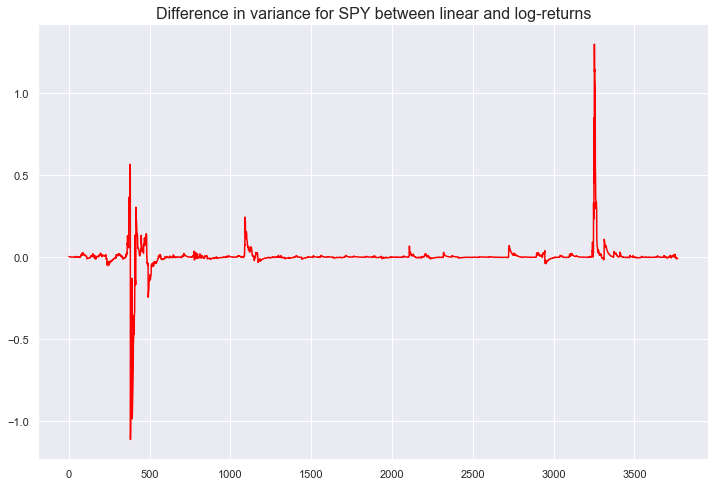

In [7]:
sns.set()
plt.figure(figsize=(12,8))
plt.plot(EWMALogreturns[0,0,:] - EWMALinearreturns[0,0,:], color = 'red')
plt.title('Difference in variance for SPY between linear and log-returns', size = 16)
plt.show()

#Makes sense since linear ret \approx 1 + log(logret). Only under 2008 and covid crisis, we observe a small difference.
#From now on we use log-returns for temporal modelling and linear returns for portfolio management. 

In [8]:
# Redefine returns under a train test split. 
# There is no reason for a train test split on the EWMA model, since we have no parameter to estimate under the train set. 
# The focus will be on the portfolio and not the modelling. Thus we will observe how the all-weather portfolio fares with a simple EWMA model in the train set. 

#Calculating excess linear and log-returns by subtracting the risk-free rate. 

TrainDF, TestDF = train_test_split(DF, test_size = 0.2, shuffle = False)

TrainLogReturns = pd.DataFrame(np.diff(np.log(TrainDF.iloc[:,0:5]), axis =  0), index=TrainDF.index[1:], columns=TrainDF.columns[0:5]).subtract(np.log(1 + TrainDF['RF'][1:]), axis = 0)
TrainLinReturns = pd.DataFrame(TrainDF.iloc[:,0:5].pct_change().dropna() , index=TrainDF.index[1:], columns=TrainDF.columns[0:5]).subtract(TrainDF['RF'][1:], axis = 0)

TestLogReturns = pd.DataFrame(np.diff(np.log(TestDF.iloc[:,0:5]), axis =  0), index=TestDF.index[1:], columns=TestDF.columns[0:5]).subtract(np.log(1 + TestDF['RF'][1:]), axis = 0)
TestLinReturns = pd.DataFrame(TestDF.iloc[:,0:5].pct_change().dropna() , index=TestDF.index[1:], columns=TestDF.columns[0:5]).subtract(TestDF['RF'][1:], axis = 0)

RFLinRetTrain, RFLinRetTest = train_test_split(DF['RF'], test_size = 0.2, shuffle = False)

#re-add DF: 

TrainLinReturns = pd.merge(TrainLinReturns, RFLinRetTrain, how = 'inner', on = 'Date')
TestLinReturns = pd.merge(TestLinReturns, RFLinRetTest, how = 'inner', on = 'Date')

In [9]:
EWMATrain = EWMA(TrainLogReturns)

Weights = np.zeros((5, EWMATrain.shape[2]))
WeightsScaled = np.zeros((5, EWMATrain.shape[2]))
LC_weights = np.zeros(EWMATrain.shape[2])
PortfolioRisk = np.zeros(EWMATrain.shape[2])
PortfolioRiskScaled = np.zeros(EWMATrain.shape[2])


b = np.ones(EWMATrain.shape[0])/EWMATrain.shape[0]
for i in range(EWMATrain.shape[2]):
    temp = Riskparity(EWMATrain[:,:,i], b, 0.1/np.sqrt(252)) #if we want 0.1 (10%) annualized volatility then we need to downscale it to daily, 0.1/np.sqrt(252)?

    WeightsScaled[:,i] = temp['w_new']
    Weights[:,i] = temp['w']
    LC_weights[i] = temp['LC_weight']
    PortfolioRisk[i] = temp['portrisk']
    PortfolioRiskScaled[i] = temp['portrisk_new']

    
Weights = pd.DataFrame(Weights.T, index = TrainLogReturns.index, columns=TrainLogReturns.columns.values)
WeightsScaled = pd.DataFrame(WeightsScaled.T, index = TrainLogReturns.index, columns=TrainLogReturns.columns.values)
LC_weights = pd.DataFrame(LC_weights.T, index = TrainLogReturns.index)
LC_weights = LC_weights.rename(columns={0: 'RF'})
#Note to self: internal sympy solver slows down computation, from 41s -> 2m10s  

c:\ProgramData\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [517]:
# first and foremost disregard leverage cost and then model everything else. 
# be aware that leveraged asset should have no volatility as it should be risk-free. --> long-term treasuries or bank account. 
# Transaction cost can simplitically be calculated by some percentage of daily turnover. 

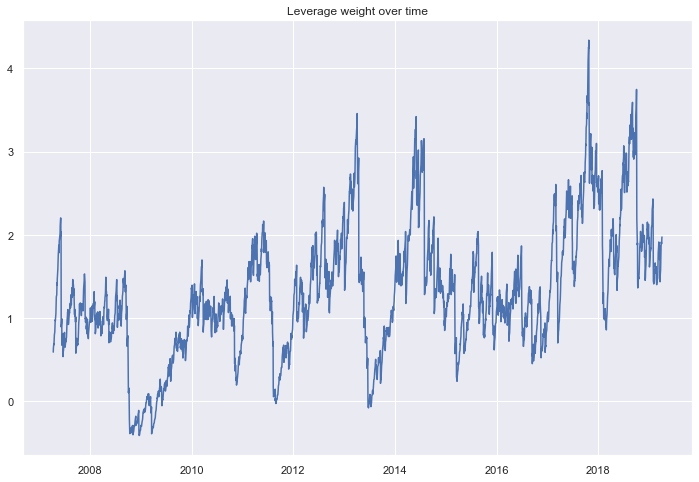

In [12]:
sns.set()
plt.figure(figsize=(12,8))
plt.plot(TrainDF.index[1:], LC_weights)
plt.title('Leverage weight over time')
plt.show()
#There is a considerable leverage in the portfolio under a 10% annualized volatility target. 

Our rebalancing methodology is done in a non-conventional manner: We assume that we still have daily data available, but only rebalace each week/month in order to save on transaction costs. That way, we still want to utilize as much information as possible, thus fitting the model on daily stock data. 

In [13]:
#We need the turnover for all assets we invest in or borrow from. Nothing is free. 
# We will work with proportional transaction costs as done in De Miguel paper. 



# Daily rebalancing
CollectedWeights = pd.concat([WeightsScaled, LC_weights], axis = 1)
TurnoverLevRiskParity = Turnover(WeightsScaled)
TurnoverRiskParity = Turnover(Weights)


# "Weekly rebalancing", converted back into daily dates. Weights are repeated until they are updated each week: 
#.ffill() is forward fill and fills out all nan values forward until new value arrives eg. [1, na, na, 2, na, na].ffill() = [1,1,1,2,2,2]
CollectedWeights_weekly = pd.concat([WeightsScaled.resample('w').last(), LC_weights.resample('w').last()], axis = 1).resample('D').last().ffill()
TurnoverLevRiskParity_weekly = Turnover(WeightsScaled.resample('w').last().resample('D').last().ffill())

Weights_weekly = Weights.resample('w').last().resample('D').last().ffill()
TurnoverRiskParity_weekly = Turnover(Weights_weekly)


# "Monthly rebalancing": 
CollectedWeights_monthly = pd.concat([WeightsScaled.resample('M').last(), LC_weights.resample('M').last()], axis = 1).resample('D').last().ffill()
TurnoverLevRiskParity_monthly = Turnover(WeightsScaled.resample('M').last().resample('D').last().ffill())

Weights_monthly = Weights.resample('M').last().resample('D').last().ffill()
TurnoverRiskParity_monthly = Turnover(Weights_monthly)


#portfolio returns can now be calculated (net of transaction cost) as: r_t = w^T * r_t^e - c * TO_t, where r_t^e is the excess return.



In [14]:
#portfolio returns can now be calculated (net of transaction cost) as: r_t = w^T * r_t^e - c * TO_t, where r_t^e is the excess return.

# Transaction cost
c = 0.005 # 50 bp in De Miguel


PortReturnsLevRiskParity = np.zeros(TrainLinReturns.shape[0])
PortReturnsRiskParity = np.zeros(TrainLinReturns.shape[0])

PortReturnsLevRiskParity_weekly = np.zeros(TrainLinReturns.shape[0])
PortReturnsRiskParity_weekly = np.zeros(TrainLinReturns.shape[0])

PortReturnsLevRiskParity_monthly = np.zeros(TrainLinReturns.shape[0])
PortReturnsRiskParity_monthly = np.zeros(TrainLinReturns.shape[0])



#Scaling returns as done in Volatility targeting, 

#daily rebalancing
for i in range(TrainLinReturns.shape[0]-1):
    PortReturnsLevRiskParity[i] = np.subtract(np.dot(CollectedWeights.iloc[i,:], TrainLinReturns.iloc[i,:]), c * TurnoverLevRiskParity[i])
    PortReturnsRiskParity[i] = np.subtract(np.dot(Weights.iloc[i,:], TrainLinReturns.iloc[i,0:5]), c * TurnoverRiskParity[i]) #TrainLinReturns.iloc[i,0:5]

#weekly rebalancing
for i in range(TrainLinReturns.shape[0]-1):
    PortReturnsLevRiskParity_weekly[i] = np.subtract(np.dot(CollectedWeights_weekly.iloc[i,:], TrainLinReturns.iloc[i,:]), c * TurnoverLevRiskParity_weekly[i])
    PortReturnsRiskParity_weekly[i] = np.subtract(np.dot(Weights_weekly.iloc[i,:], TrainLinReturns.iloc[i,0:5]), c * TurnoverRiskParity_weekly[i]) 

#monthly rebalancing:
for i in range(TrainLinReturns.shape[0]-1):
    PortReturnsLevRiskParity_monthly[i] = np.subtract(np.dot(CollectedWeights_monthly.iloc[i,:], TrainLinReturns.iloc[i,:]), c * TurnoverLevRiskParity_monthly[i])
    PortReturnsRiskParity_monthly[i] = np.subtract(np.dot(Weights_monthly.iloc[i,:], TrainLinReturns.iloc[i,0:5]), c * TurnoverRiskParity_monthly[i]) 




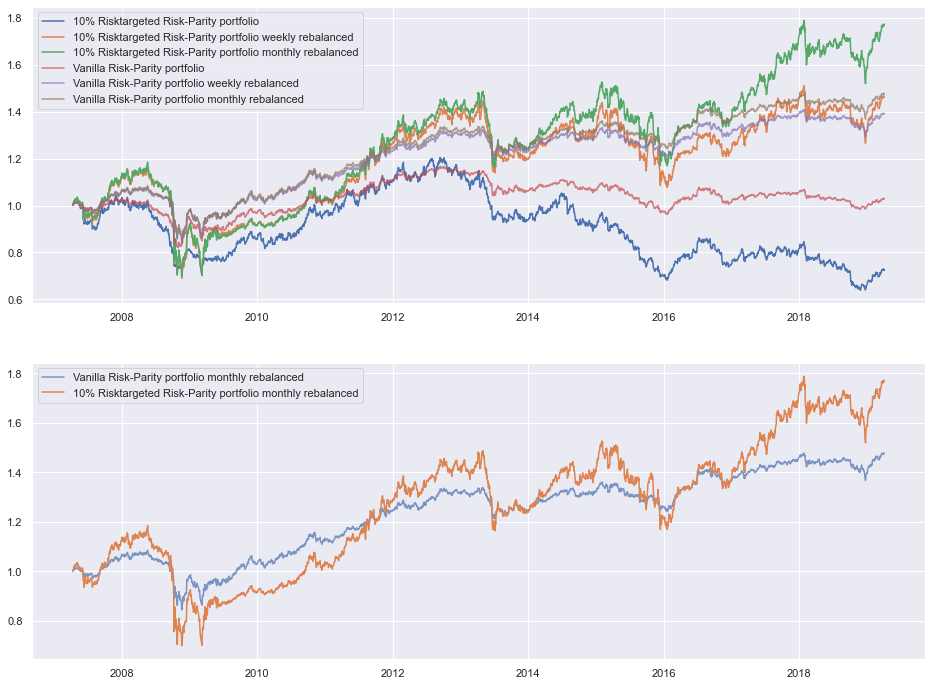

In [15]:
#limitations on  investing in the riskfree asset. Turnover is only calculated on risky assets, aka not the riskfree rate. 


#Cumulative returns is the same as the wealth function (16) defined in DeMiguels paper (this has been tested)
CumRetLevRiskParity = pd.DataFrame((1 + PortReturnsLevRiskParity).cumprod(), index = TrainLinReturns.index)
CumRetRiskParity = pd.DataFrame((1 + PortReturnsRiskParity).cumprod(), index = TrainLinReturns.index)
CumRetRiskParity_weekly = pd.DataFrame((1 + PortReturnsRiskParity_weekly).cumprod(), index = TrainLinReturns.index) 
CumRetRiskParity_monthly = pd.DataFrame((1 + PortReturnsRiskParity_monthly).cumprod(), index = TrainLinReturns.index) 
CumRetLevRiskParity_weekly = pd.DataFrame((1 + PortReturnsLevRiskParity_weekly).cumprod(), index = TrainLinReturns.index)
CumRetLevRiskParity_monthly = pd.DataFrame((1+PortReturnsLevRiskParity_monthly).cumprod(), index = TrainLinReturns.index)


fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(16,12))
ax[0].plot(CumRetLevRiskParity, label = '10% Risktargeted Risk-Parity portfolio')
ax[0].plot(CumRetLevRiskParity_weekly, label = '10% Risktargeted Risk-Parity portfolio weekly rebalanced')
ax[0].plot(CumRetLevRiskParity_monthly, label = '10% Risktargeted Risk-Parity portfolio monthly rebalanced')
ax[0].plot(CumRetRiskParity, label = 'Vanilla Risk-Parity portfolio', alpha = 0.7)
ax[0].plot(CumRetRiskParity_weekly, label = 'Vanilla Risk-Parity portfolio weekly rebalanced', alpha = 0.7)
ax[0].plot(CumRetRiskParity_monthly, label = 'Vanilla Risk-Parity portfolio monthly rebalanced', alpha = 0.7)
ax[0].legend()

ax[1].plot(CumRetRiskParity_monthly, label = 'Vanilla Risk-Parity portfolio monthly rebalanced', alpha = 0.7)
ax[1].plot(CumRetLevRiskParity_monthly, label = '10% Risktargeted Risk-Parity portfolio monthly rebalanced')
ax[1].legend()

plt.show()


<Figure size 1152x720 with 0 Axes>

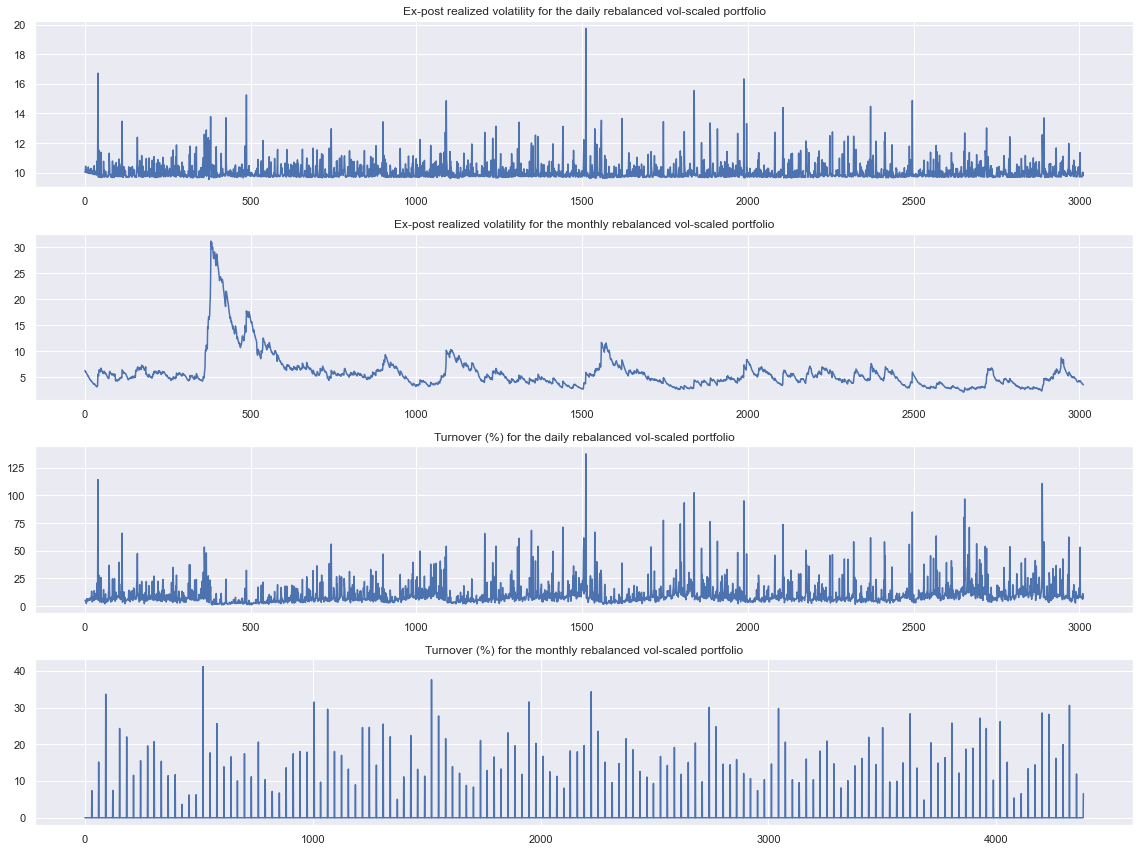

In [39]:

#this is not the right portfolio risk. Comes after the rebalancing. w_t^T * sigma_t+1 w_t

#Ex-post realized portfolio risk: 
plt.figure(figsize=(16,10))

RealizedVolatility = np.zeros(TrainLinReturns.shape[0]-1)
RealizedVolatilityMonthly = np.zeros(TrainLinReturns.shape[0]-1)
RealizedVolatilityWeekly = np.zeros(TrainLinReturns.shape[0]-1)


for i in range(TrainLinReturns.shape[0]-1):
    RealizedVolatility[i] = np.sqrt(np.dot(WeightsScaled.iloc[i,:].T, np.dot(EWMALinearreturns[:,:,i+1], WeightsScaled.iloc[i,:]))) 
    RealizedVolatilityWeekly[i] = np.sqrt(np.dot(Weights_weekly.iloc[i,:].T, np.dot(EWMALinearreturns[:,:,i+1], Weights_weekly.iloc[i,:]))) 
    RealizedVolatilityMonthly[i] = np.sqrt(np.dot(Weights_monthly.iloc[i,:].T, np.dot(EWMALinearreturns[:,:,i+1], Weights_monthly.iloc[i,:]))) 


fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize=(16,12))
ax[0].plot(RealizedVolatility * np.sqrt(252))
ax[0].set_title('Ex-post realized volatility for the daily rebalanced vol-scaled portfolio')
ax[1].plot(RealizedVolatilityMonthly * np.sqrt(252))
ax[1].set_title('Ex-post realized volatility for the monthly rebalanced vol-scaled portfolio')
ax[2].plot(TurnoverLevRiskParity * 100)
ax[2].set_title('Turnover (%) for the daily rebalanced vol-scaled portfolio')
ax[3].plot(TurnoverRiskParity_monthly * 100)
ax[3].set_title('Turnover (%) for the monthly rebalanced vol-scaled portfolio')


plt.tight_layout()
plt.show()


<AxesSubplot:xlabel='Date'>

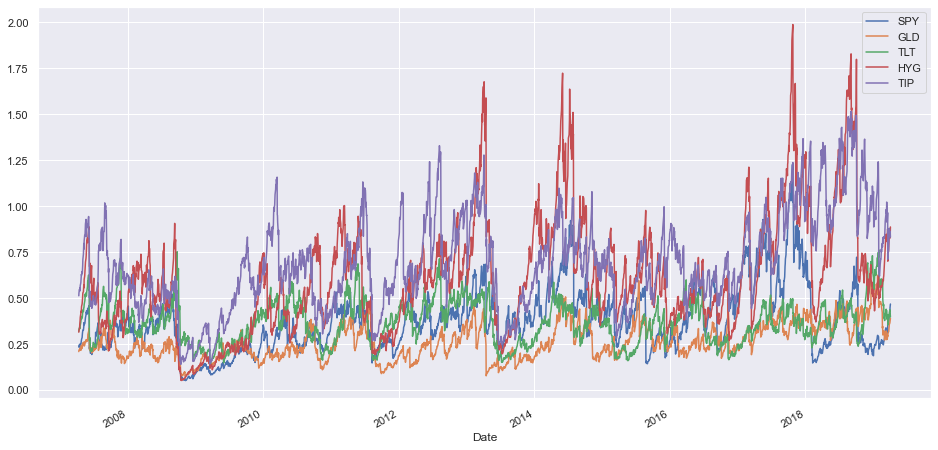

In [51]:
WeightsScaled.plot(figsize=(16,8))